### Difference between layers & tensors
**Layers are used to construct a deep learning model, and tensors are used to define the data flow through the mode**

In [1]:
# Import Input from keras.layers
from keras.layers import Input, Dense

# Create an input layer of shape 1
input_tensor = Input(shape=(1,))
print('Tensor: ', type(input_tensor))

Tensor:  <class 'keras.engine.keras_tensor.KerasTensor'>


In [2]:
# Input layer
input_tensor = Input(shape=(1,))

# Dense layer
output_layer = Dense(1)
print('Layer or function: ',type(output_layer))

# Connect the dense layer to the input_tensor
# Create output layer and output tensor at the same time
output_tensor = output_layer(input_tensor)

Layer or function:  <class 'keras.layers.core.dense.Dense'>


In [3]:
from keras.layers import Input, Dense
input_tensor = Input(shape=(1,))
output_tensor = Dense(1)(input_tensor)

# Build the model
from keras.models import Model
model = Model(input_tensor, output_tensor)

In [4]:
model.compile(optimizer='adam', loss='mean_absolute_error')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


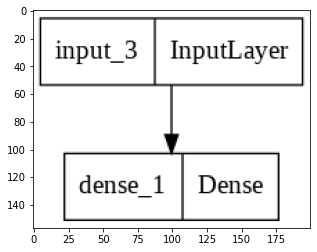

In [5]:
# Import the plotting function
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

# Summarize the model
model.summary()

# Plot the model
plot_model(model, to_file='model.png')

# Display the image
data = plt.imread('model.png')
plt.imshow(data)
plt.show()

### Fit the previous model into our basketball data

In [6]:
# The term seed can be termed same as a 'walkover' given to the team that has performed well in the same competition
# The team with 1 seed is very good and the team with 16 seed is very bad tead
# So in you input the seed differences will range from -15 to 15
# Your input will be the difference in seed between the two teams. 
# Your output will be the difference in score between the two teams.
# So a positive seed difference is usually predictive of a negative score difference, and a negative seed difference is usually predictive of a positive score difference. 
import pandas as pd

games = pd.read_csv('/content/games_tourney.csv')
games.sample(5)

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
3989,2016,7990,3299,0,5,-16,52,68,0
2714,2006,8937,4753,0,-8,-1,57,58,0
2046,2001,1155,2962,0,1,-12,70,82,0
3321,2011,1039,1805,0,-5,-12,41,53,0
4018,2016,6573,5243,0,5,7,70,63,1


In [7]:
model.fit(games['seed_diff'], games['score_diff'], batch_size=64, validation_split=0.2 , verbose=True)
# model.evaluate()

53/53 [==============================] - 1s 8ms/step - loss: 19.2086 - val_loss: 17.9355


### Category embeddings

In [8]:
games_season = pd.read_csv('/content/games_season.csv')
games_season.sample(5)

,season,team_1,team_2,home,score_diff,score_1,score_2,won
159772,1985,4941,2340,1,-13,73,86,0
223891,2001,3727,10734,0,-3,73,76,0
198237,1995,2384,8449,0,-13,77,90,0
99976,2008,1471,8685,1,8,74,66,1
153381,2018,6829,355,0,4,76,72,1


In [9]:
# In this lesson, you will learn how to use those team IDs as inputs to a model that learns the strength of each team. 
unique_teams_ids = len(pd.unique(games_season['team_1']))

print(unique_teams_ids)

10888


In [10]:
from keras.layers import Embedding, Flatten
# Notice that our embedding layer has about 11,000 parameters to learn

input_tensor = Input((1, ))
embed_layer = Embedding(input_dim = unique_teams_ids,
                        input_length = 1,
                        output_dim = 1,
                        name = 'Team-Strenght-lookup')

embed_tensor = embed_layer(input_tensor)
flatten_tensor = Flatten()(embed_tensor)
out_layer = Dense(1, activation='relu')(flatten_tensor)
team_strength_model = Model(input_tensor, flatten_tensor)
team_strength_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 Team-Strenght-lookup (Embed  (None, 1, 1)             10888     
 ding)                                                           
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
Total params: 10,888
Trainable params: 10,888
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer = 'adam', loss='mse')
model.fit(games_season['team_1'], games_season['won'])

9756/9756 [==============================] - 25s 3ms/step - loss: 5702437.0000


In [12]:
model.predict([9964])

array([[0.17232192]], dtype=float32)

### Shared layers

In [13]:
# Tow inputs to the same layer
input_tensor_1 = Input((1,))
input_tensor_2 = Input((1,))

shared_layer = Dense(1)

output_tensor_1 = shared_layer(input_tensor_1)
output_tensor_2 = shared_layer(input_tensor_2)

model_1 = Model(input_tensor_1, output_tensor_1)

In [14]:
# You will create a model with two inputs: one for each team in the basketball dataset.
# Load the input layer from keras.layers
from keras.layers import Input

# Input layer for team 1
team_in_1 = Input(shape=(1,), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input(shape=(1,), name='Team-2-In')

In [15]:
team_1_strength = model(team_in_1)
team_2_strength = model(team_in_2)

### Merge layers

In [16]:
# To compine two input layers to predicta single output we need merge layer
from keras.layers import Add

input_tensor_3 = Input((1,))
# Note that all of the inputs are required to have the same shape, so they can be combined element-wise. The Subtract and Multiply layers work the same way. 
out_tensor = Add()([input_tensor_1, input_tensor_2, input_tensor_3])

model = Model([input_tensor_1, input_tensor_2, input_tensor_3], out_tensor)

In [17]:
model.compile(optimizer='adam', loss='mae')

In [18]:
model.fit([games_season['score_diff'], games_season['score_1'], games_season['score_2']], games_season['won'])

9756/9756 [==============================] - 11s 1ms/step - loss: 140.9109


In [19]:
import numpy as np
model.predict([np.array([[1]]),
              np.array([[2]]),
              np.array([[3]])])

array([[6.]], dtype=float32)

In [20]:
model.evaluate([np.array([[-1]]),
              np.array([[-2]]),
              np.array([[-3]])], np.array([[-6]]))

1/1 [==============================] - 0s 73ms/step - loss: 0.0000e+00


0.0

In [21]:
in_tensor_1 = Input((1,))
in_tensor_2 = Input((1,))

out_layer = Add()
out_tensor = out_layer([in_tensor_1, in_tensor_2])
model = Model([in_tensor_1, in_tensor_2], out_tensor)
model.compile(optimizer='adam', loss='mae')
model.fit([games_season['team_1'], games_season['team_2']], games_season['score_diff'], epochs=1, batch_size=2048, verbose=True)

153/153 [==============================] - 0s 1ms/step - loss: 10901.5576


In [22]:
print(model.evaluate([games['team_1'], games['team_2']], games['score_diff'], verbose=False))

11178.2919921875


### Three-input models

In [23]:
from keras.layers import Concatenate

in_1_tensor = Input((1,))
in_2_tensor = Input((1,))
in_3_tensor = Input((1,))

out_tensor = Concatenate()([in_1_tensor, in_2_tensor, in_3_tensor])
output_tensor =  Dense(1)(out_tensor)
model = Model([in_1_tensor, in_2_tensor, in_3_tensor], output_tensor)

### Shared layers with 3 inputs

In [24]:
in_1_tensor = Input((1,))
in_2_tensor = Input((1,))
in_3_tensor = Input((1,))

# These two features we are applying ambedding step to them 
team_1_strength = team_strength_model(in_1_tensor)
team_2_strength = team_strength_model(in_2_tensor)

out_tensor = Concatenate()([team_1_strength, team_2_strength, in_3_tensor])
out_tensor = Dense(1)(out_tensor)
model = Model([in_1_tensor, in_2_tensor, in_3_tensor], out_tensor)
model.compile(optimizer='sgd', loss='mae')

In [25]:
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']], games_season['score_diff'], epochs=1, batch_size=2048, verbose=True)

153/153 [==============================] - 1s 2ms/step - loss: 12.0653


In [26]:
model.evaluate([games['team_1'], games['team_2'], games['home']],
               games['score_diff'], verbose=False)

11.689016342163086

### Summarizing and plotting models

###### A model's trainable parameters are usually in it's Dense layers<br>
######  It's important to remember that embedding layers often add a very large number of trainable parameters to a model.

In [27]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 model_1 (Functional)           (None, 1)            10888       ['input_13[0][0]',               
                                                                  'input_14[0][0]']               
                                                                                                  
 input_15 (InputLayer)          [(None, 1)]          0           []                         

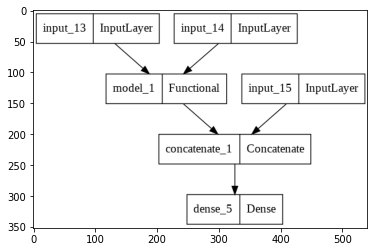

In [28]:
# Plot the model
plot_model(model, to_file='model.png')

# Display the image
data = plt.imread('model.png')
plt.imshow(data)
plt.show()

### Stacking models
**using the predictions from one model as an input to another model**

In [29]:
# Add the predictions of games_tourney from the games_season model.
games['pred'] = model.predict([games['team_1'], games['team_2'], games['home']])

input_tensor = Input((3,))
output_tensor = Dense(1)(input_tensor)
model = Model(input_tensor, output_tensor)

model.compile(optimizer='adam', loss='mean_absolute_error')

# While fitting the model using the games_tourney data we will not fit using team_1 and team_2 because they are already extracted from games_season model and added to games_tourney data as pred column
model.fit(games[['home', 'seed_diff', 'pred']],
          games['score_diff'],
          epochs=1,
          verbose=True)

print(model.evaluate(games[['home', 'seed_diff', 'pred']],
               games['score_diff'], verbose=False))

133/133 [==============================] - 0s 1ms/step - loss: 12.5426
12.283431053161621


### Multiple Outputs

In [30]:
# Define the input
input_tensor = Input((2, ))

# Define the output
output_tensor = Dense(2)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(games[['seed_diff', 'pred']],
  		  games[['score_1', 'score_2']],
  		  verbose=True,
          epochs=100,
  		  batch_size=16384)

print(model.evaluate(games[['seed_diff', 'pred']],
               games[['score_1', 'score_2']], verbose=False))

Epoch 1/100
1/1 [==============================] - 0s 298ms/step - loss: 71.1313
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 71.1303
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 71.1293
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 71.1283
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 71.1273
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 71.1263
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 71.1253
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 71.1243
Epoch 9/100
1/1 [==============================] - 0s 12ms/step - loss: 71.1233
Epoch 10/100
1/1 [==============================] - 0s 8ms/step - loss: 71.1223
Epoch 11/100
1/1 [==============================] - 0s 15ms/step - loss: 71.1213
Epoch 12/100
1/1 [==============================] - 0s 11ms/step - loss: 71.1203
Epoch 13/100
1/1 [=========================

### Single model for classification and regression

In [31]:
# Rather than using two regression outputs, We have a regression output and a classification output.

In [32]:
# Create an input layer with 2 columns
input_tensor = Input((2,))

# Create the first output(FOR REGRESSION OUTPUT)
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)

# Create the second output (use the first output as input here)(FOR CLASSIFICATION OUTPUT)
output_tensor_2 = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_1)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1, output_tensor_2])

In [33]:
# Import the Adam optimizer
from tensorflow.keras.optimizers import Adam

# Compile the model with 2 losses and the Adam optimzer with a higher learning rate
model.compile(loss=['mean_absolute_error', 'binary_crossentropy'], optimizer=Adam(0.01))

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(games[['seed_diff', 'pred']],
          [games[['score_diff']], games[['won']]],
          epochs=10,
          verbose=True,
          batch_size=16384)

Epoch 1/10
1/1 [==============================] - 1s 565ms/step - loss: 26.3828 - dense_8_loss: 17.7294 - dense_9_loss: 8.6534
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 26.1999 - dense_8_loss: 17.6765 - dense_9_loss: 8.5234
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 26.0183 - dense_8_loss: 17.6238 - dense_9_loss: 8.3945
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 25.8378 - dense_8_loss: 17.5712 - dense_9_loss: 8.2666
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 25.6587 - dense_8_loss: 17.5189 - dense_9_loss: 8.1398
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 25.4809 - dense_8_loss: 17.4668 - dense_9_loss: 8.0141
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 25.3044 - dense_8_loss: 17.4149 - dense_9_loss: 7.8895
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 25.1292 - dense_8_loss: 17.3632 - dense_9_loss: 7.766

In [34]:
print(model.evaluate(games[['seed_diff', 'pred']],
               [games[['score_diff']], games[['won']]], verbose=False))

[24.61084747314453, 17.208532333374023, 7.402312278747559]


##### In academic research, shared models are known as "siamese networks", which are used to calculate things like document similarity, using shared embedding layer and a shared long-short-term memory layer (or LSTM layer), and then comparing the LSTM outputs.